Importing original training datasets - 1. registration data and 2. previous lives.

In [57]:
import pandas as pd
import matplotlib.pyplot as plt
import pycountry_convert as pc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error


file_path = 'registration_data_training.csv'
df_registration = pd.read_csv(file_path)
file_path2 = 'previous_lives_training_data.csv'
df_previous_lives = pd.read_csv(file_path2)

Exploring two datasets.

In [58]:
df_registration.head(5)

,user_id,registration_time_utc,registration_platform_specific,registration_country,registration_store,registration_season_day,registration_channel_detailed,registration_device_type,registration_device_manufacturer,session_count,...,rests_stash,rests_spent,treatments_spent,morale_spent,money_stash,avg_stars_top_11_players,avg_stars_top_3_players,avg_age_top_11_players,training_count,days_active_first_28_days_after_registration
0,5,2024-05-25 01:26:48.000,iOS Phone,France,AppStore,7,Organic,Phone,Apple,1,...,524,0,0,0,1066076772,4.721867,5.451511,22.0,0,0
1,7,2024-06-14 20:09:31.000,Android Phone,Turkey,GooglePlay,27,Unknown,Phone,Xiaomi,1,...,962,0,0,0,1224446429,4.911067,5.303822,22.0,1,0
2,13,2024-05-31 09:06:51.000,Android Phone,Belarus,GooglePlay,13,Organic,Phone,Xiaomi,2,...,829,0,0,0,1221792142,5.018146,5.746889,24.0,3,0
3,23,2024-05-31 04:00:33.000,Android Phone,Indonesia,GooglePlay,13,Paid,Phone,OPPO,4,...,180,39,12,9,928112709,5.827455,6.692578,22.0,7,1
4,25,2024-06-15 19:56:05.000,iOS Phone,Egypt,AppStore,28,Organic,Phone,Apple,5,...,209,80,0,2,326553498,5.340412,5.775289,24.0,6,3


In [59]:
df_previous_lives.head(5)

,user_id,registration_date,registration_season_day,registration_country,registration_channel_detailed,registration_store,registration_platform_specific,is_payer_lifetime,days_active_lifetime,transaction_count_iap_lifetime,is_rewarded_video_watcher_lifetime
0,5,2022-04-21,26,France,Organic,AppStore,iOS Phone,False,1,0,False
1,5,2023-05-07,15,France,Paid,AppStore,iOS Phone,False,18,0,True
2,7,2022-04-06,11,Turkey,Organic,AppStore,iOS Phone,False,21,0,True
3,7,2023-02-06,9,Turkey,Organic,GooglePlay,Android Phone,False,2,0,False
4,7,2023-05-28,8,Turkey,Unknown,GooglePlay,Android Phone,False,1,0,False


In [60]:
# Grouping previous lives dataset by user_id, to have one row per user and creating new potentially meaningful variables (min/max/sum..)
grouped_df = df_previous_lives.groupby('user_id').agg(
    first_registration_date=('registration_date', 'min'),
    last_registration_date=('registration_date', 'max'),
    max_registration_season_day=('registration_season_day', 'max'),
    min_registration_season_day=('registration_season_day', 'min'),
    last_registration_season_day=('registration_season_day', 'last'),
    is_payer_lifetime=('is_payer_lifetime', 'max'),
    max_days_active_lifetime=('days_active_lifetime', 'max'),
    min_days_active_lifetime=('days_active_lifetime', 'min'),
    last_days_active_lifetime=('days_active_lifetime', 'last'),
    sum_days_active_lifetime=('days_active_lifetime', 'sum'),
    transaction_count_iap_lifetime=('transaction_count_iap_lifetime', 'sum'),
    is_rewarded_video_watcher_lifetime=('is_rewarded_video_watcher_lifetime', 'max'),
    number_of_previous_lives=('user_id', 'count'),
    ever_organic=('registration_channel_detailed', lambda x: 'Organic' in x.values ),
    ever_paid=('registration_channel_detailed', lambda x: 'Paid' in x.values),
    ever_appstore=('registration_store', lambda x: 'AppStore' in x.values),
    ever_googleplay=('registration_store', lambda x: 'GooglePlay' in x.values)
).reset_index()


print(grouped_df.head(4))


   user_id first_registration_date last_registration_date  \
0        5              2022-04-21             2023-05-07   
1        7              2022-04-06             2023-05-28   
2       13              2022-10-18             2023-08-17   
3       23              2023-08-30             2023-08-30   

   max_registration_season_day  min_registration_season_day  \
0                           26                           15   
1                           11                            8   
2                           10                            5   
3                           18                           18   

   last_registration_season_day  is_payer_lifetime  max_days_active_lifetime  \
0                            15              False                        18   
1                             8              False                        21   
2                             5              False                       221   
3                            18              False        

In [61]:
# Merging the grouped dataset for previous lives and original dataset for registration data on 'user_id'
merged_df = df_registration.merge(grouped_df, on='user_id', suffixes=('', '_grouped'))

Exploring distribution of outcome variable. By looking at histogram.

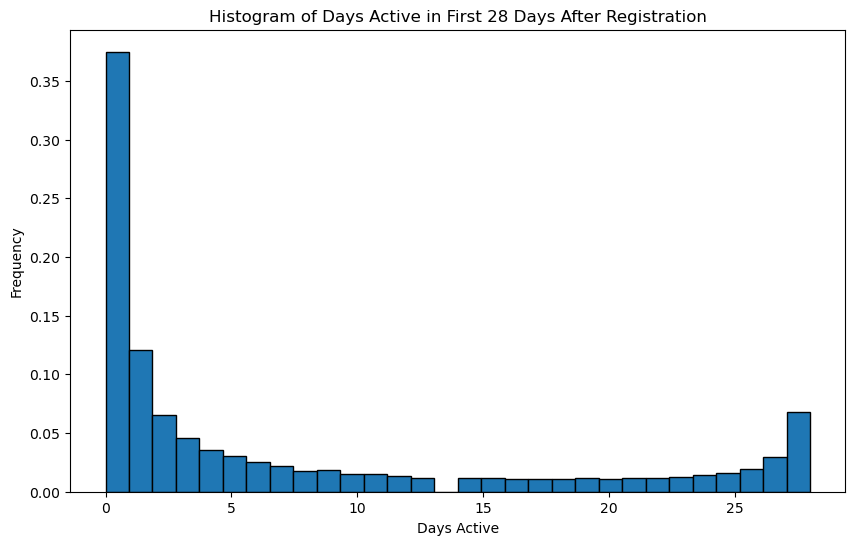

In [62]:
# Plot histogram for the target variable 'days_active_first_28_days_after_registration'
plt.figure(figsize=(10, 6))
plt.hist(merged_df['days_active_first_28_days_after_registration'], bins=30, edgecolor='black', density= True)
plt.title('Histogram of Days Active in First 28 Days After Registration')
plt.xlabel('Days Active')
plt.ylabel('Frequency')
plt.show()


Exploring variables:

Exploring registration_country to see how many users are from each. To potentially group countries in new variable.

In [63]:
    # Calculate the top 10 countries
    top_countries = (
        merged_df['registration_country']
        .value_counts()
        .head(10)
        .reset_index()
        .rename(columns={'index': 'Country', 'registration_country': 'Participants'})
    )
    
    # Display the results
    print("Top 10 Registration Countries by Number of Participants:")
    print(top_countries)

Top 10 Registration Countries by Number of Participants:
     Participants  count
0       Indonesia  12018
1          Turkey   4472
2          Brazil   3067
3         Germany   2130
4  United Kingdom   1700
5          France   1619
6        Thailand   1544
7           Italy   1339
8           Spain   1236
9        Malaysia   1162


Keep countries with more than 400 users. Group countries with less than 400 by continent.

In [64]:
# Predefine the mapping of continent codes to names
CONTINENT_NAME_MAP = {
    'AF': 'Africa',
    'AS': 'Asia',
    'EU': 'Europe',
    'NA': 'North America',
    'SA': 'South America',
    'OC': 'Oceania',
    'AN': 'Antarctica'
}

def map_country_to_region(country_name, country_counts, threshold=400):
    try:
        # Handle missing or null values
        if pd.isna(country_name):
            return 'Other_Unknown'
        
        # Check if the country count exceeds the threshold
        if country_counts.get(country_name, 0) > threshold:
            return country_name  # Keep the country as is
        
        # Convert country name to country code
        country_code = pc.country_name_to_country_alpha2(country_name)
        
        # Map country code to continent code
        continent_code = pc.country_alpha2_to_continent_code(country_code)
        
        # Group under "Other_<Continent>"
        return f"Other_{CONTINENT_NAME_MAP.get(continent_code, 'Unknown')}"
    except (KeyError, ValueError):
        # Handle unknown or invalid country names
        return 'Other_Unknown'

# Count occurrences of each country
country_counts = merged_df['registration_country'].value_counts()

# Apply the function with the threshold logic
merged_df['region'] = merged_df['registration_country'].apply(
    lambda x: map_country_to_region(x, country_counts)
)

# Check unique regions created
unique_regions = merged_df['region'].unique()
print("Unique regions:", unique_regions)




Unique regions: ['France' 'Turkey' 'Other_Europe' 'Indonesia' 'Egypt' 'Spain' 'Brazil'
 'Germany' 'Other_Asia' 'Malaysia' 'Poland' 'Romania' 'Israel' 'Italy'
 'Greece' 'Saudi Arabia' 'Other_Unknown' 'India' 'Other_Africa'
 'United States' 'United Kingdom' 'Czech Republic' 'Argentina' 'Serbia'
 'Portugal' 'Thailand' 'Other_South America' 'Other_North America'
 'Mexico' 'Other_Oceania']


In [65]:
# Count the number of occurrences for each region
region_counts = merged_df['region'].value_counts()
print(region_counts)


region
Indonesia              12018
Turkey                  4472
Other_Europe            3885
Brazil                  3067
Other_Asia              2724
Germany                 2130
Other_Africa            1881
United Kingdom          1700
France                  1619
Thailand                1544
Other_South America     1409
Italy                   1339
Spain                   1236
Malaysia                1162
Poland                  1160
United States            951
Argentina                852
Greece                   745
Egypt                    728
Romania                  680
Israel                   651
Portugal                 590
Mexico                   566
Czech Republic           559
India                    533
Other_North America      524
Serbia                   445
Saudi Arabia             437
Other_Oceania            241
Other_Unknown            152
Name: count, dtype: int64


Calculating time since first and last registration from date variables, and removing date variables.

In [66]:
# Convert registration_time_utc, first_registration_date, and last_registration_date to datetime 
merged_df['registration_time_utc'] = pd.to_datetime(merged_df['registration_time_utc'])
merged_df['first_registration_date'] = pd.to_datetime(merged_df['first_registration_date'])
merged_df['last_registration_date'] = pd.to_datetime(merged_df['last_registration_date'])

# Calculate days_from_first_registration and days_from_last_registration
merged_df['days_from_first_registration'] = (merged_df['registration_time_utc'] - merged_df['first_registration_date']).dt.days
merged_df['days_from_last_registration'] = (merged_df['registration_time_utc'] - merged_df['last_registration_date']).dt.days

# Display the new columns to verify
print(merged_df[['user_id', 'registration_time_utc', 'first_registration_date', 
                 'last_registration_date', 'days_from_first_registration', 'days_from_last_registration']].head(2))


   user_id registration_time_utc first_registration_date  \
0        5   2024-05-25 01:26:48              2022-04-21   
1        7   2024-06-14 20:09:31              2022-04-06   

  last_registration_date  days_from_first_registration  \
0             2023-05-07                           765   
1             2023-05-28                           800   

   days_from_last_registration  
0                          384  
1                          383  


In [67]:
# Removing all date columns from the DataFrame
merged_df = merged_df.drop(columns=['registration_time_utc', 'first_registration_date', 'last_registration_date'], errors='ignore')

In [68]:
# Drop rows with any NaN values
merged_df = merged_df.dropna()


Exploring and recoding variable for device manufacturer on registration.

In [69]:
# Get the unique values and their counts for the 'registration_device_manufacturer' column
device_manufacturer_counts = merged_df['registration_device_manufacturer'].value_counts()

# Display the counts for the first 15 unique device manufacturers
print(device_manufacturer_counts.head(10))



registration_device_manufacturer
Apple                       12068
samsung                     11815
Xiaomi                       9685
OPPO                         3119
vivo                         2298
realme                       2072
motorola                     1464
HUAWEI                       1139
INFINIX                       881
INFINIX MOBILITY LIMITED      583
Name: count, dtype: int64


Plot histograms of outcome to see distributions in different device manufacturers.

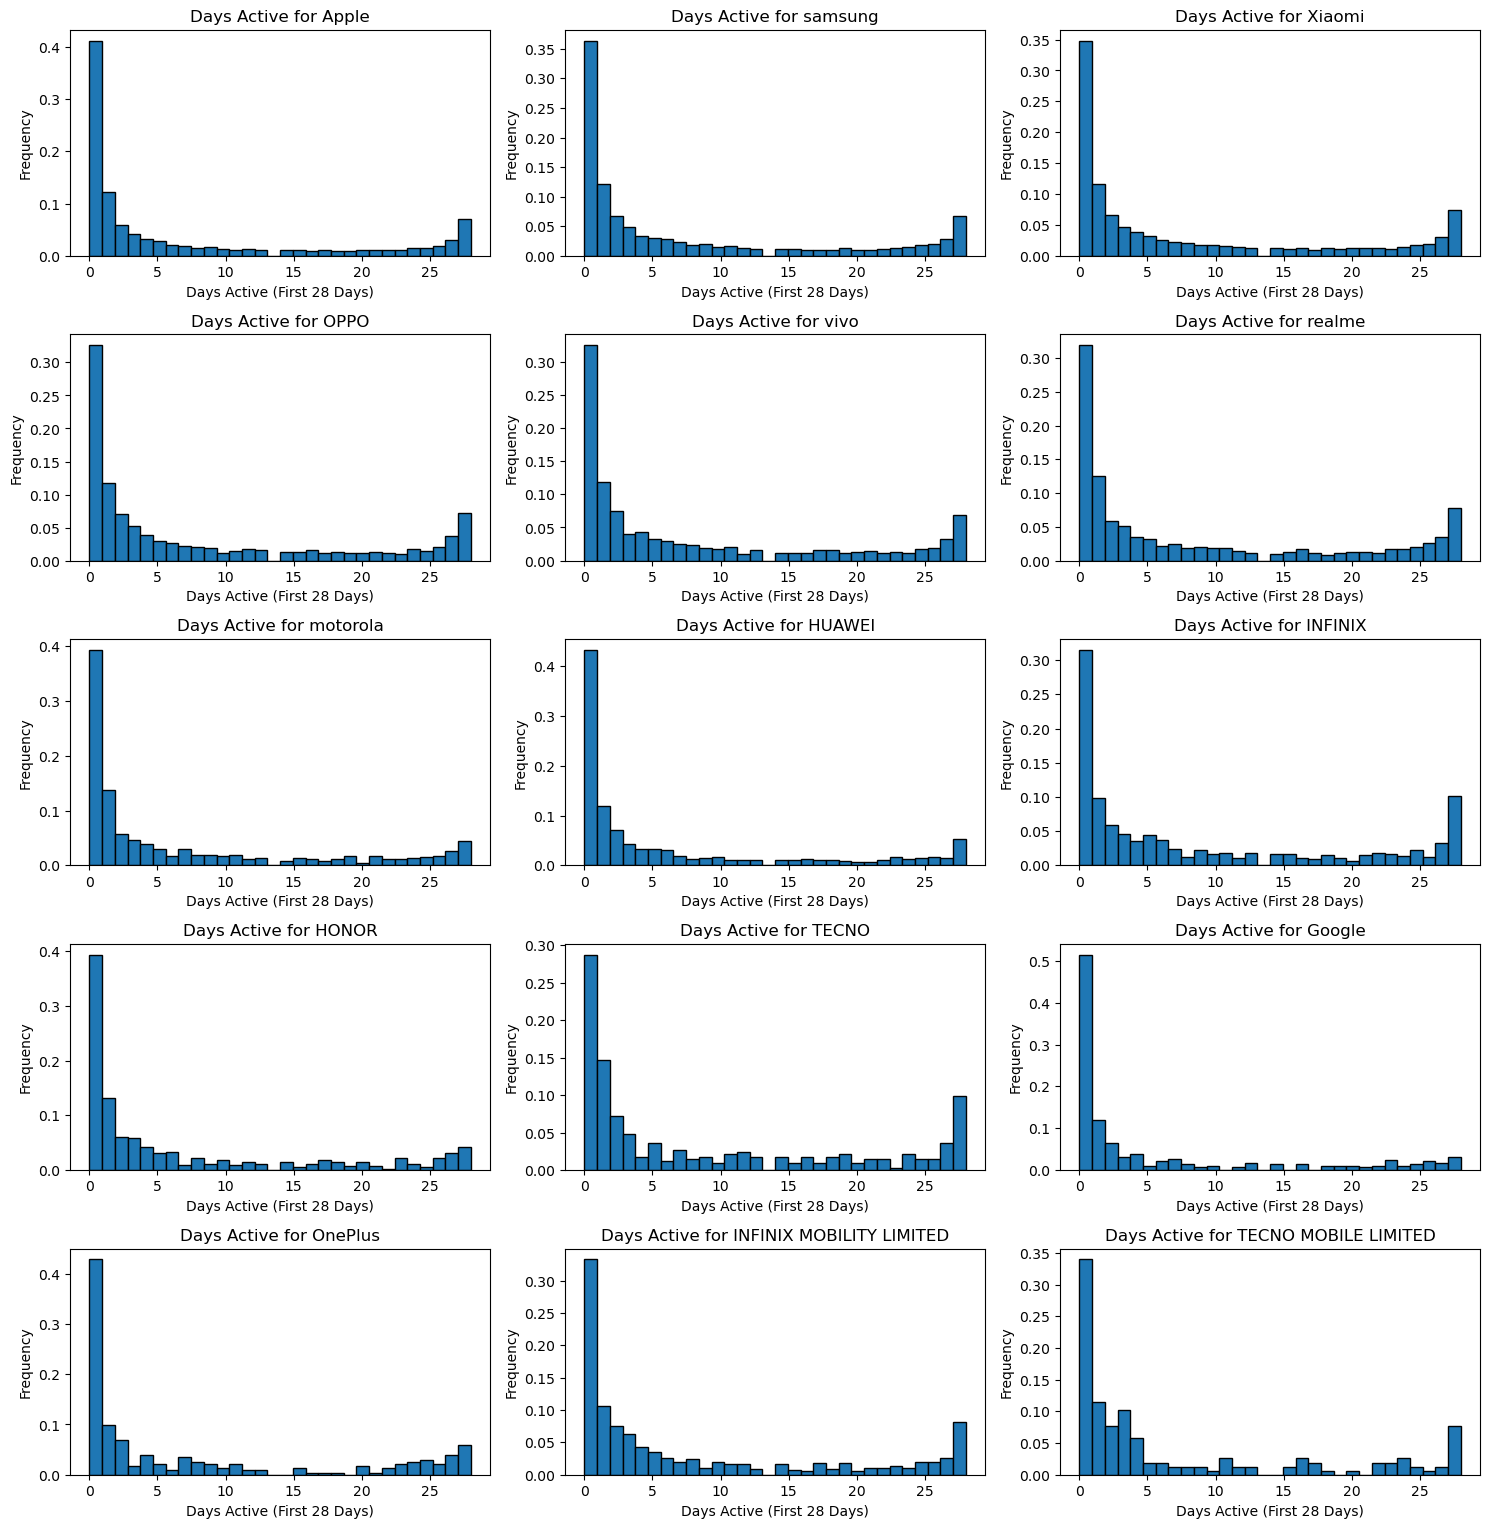

In [70]:
# Define a list of specific device manufacturers you want to plot
device_manufacturers = ['Apple', 'samsung', 'Xiaomi', 'OPPO', 'vivo', 'realme', 
                        'motorola', 'HUAWEI', 'INFINIX', 'HONOR', 'TECNO', 'Google', 
                        'OnePlus', 'INFINIX MOBILITY LIMITED', 'TECNO MOBILE LIMITED']

# Plot the histograms for each device manufacturer
plt.figure(figsize=(15, 18))  # Adjusted figure size to fit all histograms
num_rows = 6  
num_columns = 3

for i, device in enumerate(device_manufacturers, 1):
    plt.subplot(num_rows, num_columns, i) 
    device_data = merged_df[merged_df['registration_device_manufacturer'] == device]
    plt.hist(device_data['days_active_first_28_days_after_registration'], bins=30, edgecolor='black', density = True)
    plt.title(f'Days Active for {device}')
    plt.xlabel('Days Active (First 28 Days)')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()





In [71]:
# Get the top 10 most common device manufacturers
top_10_manufacturers = merged_df['registration_device_manufacturer'].value_counts().head(10).index

# Initialize a dictionary to store results
zero_percentages = {}

# Calculate percentage of 0s for each manufacturer
for manufacturer in top_10_manufacturers:
    manufacturer_data = merged_df[merged_df['registration_device_manufacturer'] == manufacturer]
    zero_percentage = (manufacturer_data['days_active_first_28_days_after_registration'] == 0).mean() * 100
    zero_percentages[manufacturer] = zero_percentage

# Display the results
for manufacturer, percentage in zero_percentages.items():
    print(f"Percentage of 0 days active for {manufacturer}: {percentage:.2f}%")


Percentage of 0 days active for Apple: 38.47%
Percentage of 0 days active for samsung: 33.97%
Percentage of 0 days active for Xiaomi: 32.52%
Percentage of 0 days active for OPPO: 30.43%
Percentage of 0 days active for vivo: 30.33%
Percentage of 0 days active for realme: 29.78%
Percentage of 0 days active for motorola: 36.68%
Percentage of 0 days active for HUAWEI: 40.39%
Percentage of 0 days active for INFINIX: 29.40%
Percentage of 0 days active for INFINIX MOBILITY LIMITED: 31.05%


In [72]:
# Get unique values and their counts for 'registration_store' and 'registration_platform_specific' columns
# Counts for 'registration_store'
store_counts = merged_df['registration_store'].value_counts()
print("Registration store counts:\n", store_counts)

# Counts for 'registration_platform_specific'
platform_specific_counts = merged_df['registration_platform_specific'].value_counts()
print("\nRegistration platform specific counts:\n", platform_specific_counts)


Registration store counts:
 registration_store
GooglePlay         35759
AppStore           12068
Huawei               249
GooglePlayForPC      105
Catappult              6
Name: count, dtype: int64

Registration platform specific counts:
 registration_platform_specific
Android Phone     34549
iOS Phone         10772
Android Tablet     1570
iOS Tablet         1296
Name: count, dtype: int64


In [73]:
# Create new columns with 'Other' for rare values in 'registration_store' and 'registration_platform_specific'

# For 'registration_store'
store_counts = merged_df['registration_store'].value_counts()
merged_df['registration_store_cleaned'] = merged_df['registration_store'].apply(lambda x: x if store_counts[x] >= 1000 else 'Other')

# For 'registration_platform_specific'
platform_counts = merged_df['registration_platform_specific'].value_counts()
merged_df['registration_platform_specific_cleaned'] = merged_df['registration_platform_specific'].apply(lambda x: x if platform_counts[x] >= 1000 else 'Other')

# Remove original columns
merged_df = merged_df.drop(columns=['registration_store', 'registration_platform_specific'])

# Display updated counts to confirm
updated_store_counts = merged_df['registration_store_cleaned'].value_counts()
updated_platform_counts = merged_df['registration_platform_specific_cleaned'].value_counts()

print("Updated registration store counts:\n", updated_store_counts)
print("\nUpdated registration platform specific counts:\n", updated_platform_counts)



Updated registration store counts:
 registration_store_cleaned
GooglePlay    35759
AppStore      12068
Other           360
Name: count, dtype: int64

Updated registration platform specific counts:
 registration_platform_specific_cleaned
Android Phone     34549
iOS Phone         10772
Android Tablet     1570
iOS Tablet         1296
Name: count, dtype: int64


In [74]:
# Remove the 'registration_country' column
merged_df = merged_df.drop(columns=['registration_country'])
merged_df = merged_df.drop(columns=['registration_device_manufacturer']) 


In [75]:
# Create train , test and validation split

# Define features (X) and target variable (y)
X = merged_df.drop(columns=['days_active_first_28_days_after_registration'])
y = merged_df['days_active_first_28_days_after_registration']


# First split into training+validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

# Split training+validation set further into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.1765, random_state=42)  


In [76]:
# Scale numeric variables
# Identify numeric columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns

# Initialize scaler
scaler = StandardScaler()

# Fit and transform numeric features in training set, and transform validation and test sets
X_train[numeric_columns] = scaler.fit_transform(X_train[numeric_columns])
X_val[numeric_columns] = scaler.transform(X_val[numeric_columns])
X_test[numeric_columns] = scaler.transform(X_test[numeric_columns])


In [77]:
y_train

23611     0
13773     6
13872     0
8189     28
36934    20
         ..
25566     0
30186     0
25738     7
635       0
25797     0
Name: days_active_first_28_days_after_registration, Length: 33728, dtype: int64

In [78]:
# Convert X_train and y_train to DataFrames 
X_train_df = pd.DataFrame(X_train)  
y_train_df = pd.DataFrame(y_train)

# Display structure and NaN/infinite value checks
print("\nX_train summary:")
print(X_train_df.info())
print("\nNaN values in X_train:", X_train_df.isnull().sum().sum())
print("\nInfinite values in X_train:", (X_train_df == float('inf')).sum().sum())

print("\nSummary of y_train:")
print(y_train_df.describe())




X_train summary:
<class 'pandas.core.frame.DataFrame'>
Index: 33728 entries, 23611 to 25797
Data columns (total 44 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   user_id                                 33728 non-null  float64
 1   registration_season_day                 33728 non-null  float64
 2   registration_channel_detailed           33728 non-null  object 
 3   registration_device_type                33728 non-null  object 
 4   session_count                           33728 non-null  float64
 5   playtime                                33728 non-null  float64
 6   number_of_devices_used                  33728 non-null  float64
 7   total_match_played_count                33728 non-null  float64
 8   total_match_won_count                   33728 non-null  float64
 9   total_match_watched_count               33728 non-null  float64
 10  transaction_count_iap                   3

In [79]:
# Convert X_test and y_test to DataFrames 
X_test_df = pd.DataFrame(X_test)  
y_test_df = pd.DataFrame(y_test)

In [80]:
# Convert X_val and y_val to DataFrames 
X_val_df = pd.DataFrame(X_val)  
y_val_df = pd.DataFrame(y_val)

In [81]:
# Check if 'user_id' exists in each dataset before trying to drop it
if 'user_id' in X_train_df.columns:
    X_train_df = X_train_df.drop(columns=['user_id'])

if 'user_id' in X_val_df.columns:
    X_val_df = X_val_df.drop(columns=['user_id'])

if 'user_id' in X_test_df.columns:
    X_test_df = X_test_df.drop(columns=['user_id'])

In [82]:
# Print the dimensions of all three DataFrames
print("Training DataFrame shape:", X_train_df.shape)
print("Validation DataFrame shape:", X_val_df.shape)
print("Test DataFrame shape:", X_test_df.shape)


Training DataFrame shape: (33728, 43)
Validation DataFrame shape: (7230, 43)
Test DataFrame shape: (7229, 43)


In [83]:
# Automatically find categorical columns in the DataFrame
categorical_columns = X_train_df.select_dtypes(include=['object', 'category']).columns.tolist()

# Apply one-hot encoding to the categorical columns
X_train_df = pd.get_dummies(X_train_df, columns=categorical_columns, drop_first=True)
X_test_df = pd.get_dummies(X_test_df, columns=categorical_columns, drop_first=True)
X_val_df = pd.get_dummies(X_val_df, columns=categorical_columns, drop_first=True)
# Verify the result
print("X_train after encoding:")
print(X_train_df.head())

print("\nX_train shape after encoding:", X_train_df.shape)



X_train after encoding:
       registration_season_day  session_count  playtime  \
23611                -0.821889      -0.601334 -0.632343   
13773                -1.442069      -0.601334 -0.625270   
13872                -0.945925      -0.127128 -0.783913   
8189                  1.286722      -0.601334 -0.094822   
36934                 0.666543       0.347078  0.267841   

       number_of_devices_used  total_match_played_count  \
23611               -0.082133                  0.593532   
13773               -0.082133                 -0.621265   
13872               -0.082133                 -0.013867   
8189                -0.082133                 -0.013867   
36934               -0.082133                 -0.013867   

       total_match_won_count  total_match_watched_count  \
23611               0.228826                   -0.37686   
13773              -0.580341                   -0.37686   
13872              -0.580341                   -0.37686   
8189                0.228826  

In [84]:
# Convert all columns in X_train_df to numeric, coerce errors to NaN (then recheck for any NaNs if needed)
X_train_df = X_train_df.apply(pd.to_numeric, errors='coerce')

# Verify that all data is numeric
print(X_train_df.dtypes)


registration_season_day                                  float64
session_count                                            float64
playtime                                                 float64
number_of_devices_used                                   float64
total_match_played_count                                 float64
                                                          ...   
registration_store_cleaned_GooglePlay                       bool
registration_store_cleaned_Other                            bool
registration_platform_specific_cleaned_Android Tablet       bool
registration_platform_specific_cleaned_iOS Phone            bool
registration_platform_specific_cleaned_iOS Tablet           bool
Length: 75, dtype: object


In [85]:
# Convert all columns in X_test_df to numeric, coerce errors to NaN (then recheck for any NaNs if needed)
X_test_df = X_test_df.apply(pd.to_numeric, errors='coerce')
X_val_df = X_val_df.apply(pd.to_numeric, errors='coerce')


In [86]:
# Convert boolean columns to integers (0 or 1)
X_train_df = X_train_df.astype({col: 'int' for col in X_train_df.select_dtypes('bool').columns})
X_test_df = X_test_df.astype({col: 'int' for col in X_test_df.select_dtypes('bool').columns})
X_val_df = X_val_df.astype({col: 'int' for col in X_val_df.select_dtypes('bool').columns})


In [87]:
# Print the dimensions of all three DataFrames
print("Training DataFrame shape:", X_train_df.shape)
print("Validation DataFrame shape:", X_val_df.shape)
print("Test DataFrame shape:", X_test_df.shape)


Training DataFrame shape: (33728, 75)
Validation DataFrame shape: (7230, 75)
Test DataFrame shape: (7229, 75)


Try simple model - Linear Regression 

In [88]:
# Initialize the Linear Regression model
linear_regressor = LinearRegression()

# Train the model on the training data
linear_regressor.fit(X_train_df, y_train)

y_test_pred = linear_regressor.predict(X_test_df).round().clip(0, 28)

test_mae = mean_absolute_error(y_test_df, y_test_pred)

print(f"Test MAE: {test_mae}")


Test MAE: 6.367547378613916


Try penalized regression - LASSO 

In [89]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

# Define the range of alpha values to search
param_grid = {'alpha': [0.01, 0.1, 1, 10]}

# Perform Grid Search with Cross-Validation
lasso = Lasso(random_state=42)
grid_search = GridSearchCV(estimator=lasso, param_grid=param_grid, 
                           scoring='neg_mean_absolute_error', cv=5, verbose=1, n_jobs=-1)
grid_search.fit(X_train_df, y_train)

# Best model and alpha
best_lasso = grid_search.best_estimator_
print(f"Best alpha: {grid_search.best_params_['alpha']}")

# Evaluate the best model
y_test_pred = best_lasso.predict(X_test_df).round().clip(0, 28)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Test MAE (Best LASSO): {test_mae}")



Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best alpha: 0.01
Test MAE (Best LASSO): 6.388297136533407


ANN - relu activation function and last activation function Sigmoid (outcome can be seen as proportion of first 28 days)

In [90]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

# Define the ANN model
model_relu = Sequential([
    Dense(512, activation='relu', input_dim=X_train_df.shape[1]),
    BatchNormalization(),
    Dropout(0.3),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(32, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(16, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model_relu.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Train the model
history = model_relu.fit(
    X_train_df, y_train / 28,  # Rescale target to 0-1
    validation_data=(X_val_df, y_val / 28),  # Rescale target to 0-1
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)


Epoch 1/50


/Users/ognjenradojicic/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


1054/1054 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 0.2769 - val_loss: 0.2087
Epoch 2/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2150 - val_loss: 0.2019
Epoch 3/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2051 - val_loss: 0.1981
Epoch 4/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.2019 - val_loss: 0.1940
Epoch 5/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1976 - val_loss: 0.1939
Epoch 6/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1984 - val_loss: 0.1949
Epoch 7/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1978 - val_loss: 0.1926
Epoch 8/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1958 - val_loss: 0.1919
Epoch 9/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1944 - val_loss: 0.1920
Epoch 10/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1926 - val_loss: 0.1913
Epoch 11/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.1912 - val_loss: 0.1929
Epoch 12/50
1054/1054 ━━━━━━━━━━━━━━━━━━━

In [91]:
# Make predictions and rescale back to 0-28
y_train_pred = (model_relu.predict(X_train_df).flatten() * 28).round().clip(0, 28)
y_val_pred = (model_relu.predict(X_val_df).flatten() * 28).round().clip(0, 28)
y_test_pred = (model_relu.predict(X_test_df).flatten() * 28).round().clip(0, 28)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")
print(f"Test MAE: {test_mae}")

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 652us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 660us/step
Training MAE: 5.135406783681215
Validation MAE: 5.3550484094052555
Test MAE: 5.371420666758888


Trying simpler ANN but with leaky ReLU activation function and lower dropout rate

In [92]:
from tensorflow.keras.layers import LeakyReLU

# Define the simplified ANN model
model_leaky = Sequential([
    Dense(256, input_dim=X_train_df.shape[1]),   
    LeakyReLU(alpha=0.1),   
    BatchNormalization(),
    Dropout(0.2),   

    Dense(128),   
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')   
])

# Compile the model
model_leaky.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Train the model
history = model_leaky.fit(
    X_train_df, y_train / 28,  # Rescale target to 0-1
    validation_data=(X_val_df, y_val / 28),  # Rescale target to 0-1
    epochs=50,
    batch_size=32,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    ],
    verbose=1
)


Epoch 1/50


/Users/ognjenradojicic/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ognjenradojicic/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.2485 - val_loss: 0.1990
Epoch 2/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2050 - val_loss: 0.1970
Epoch 3/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1963 - val_loss: 0.1962
Epoch 4/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1978 - val_loss: 0.1932
Epoch 5/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1953 - val_loss: 0.1927
Epoch 6/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1939 - val_loss: 0.1909
Epoch 7/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1938 - val_loss: 0.1922
Epoch 8/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1924 - val_loss: 0.1936
Epoch 9/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1888 - val_loss: 0.1931
Epoch 10/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1884 - val_loss: 0.1931
Epoch 11/50
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.1897 - val_loss: 0.1915


In [93]:
# Make predictions and rescale back to 0-28
y_train_pred = (model_leaky.predict(X_train_df).flatten() * 28).round().clip(0, 28)
y_val_pred = (model_leaky.predict(X_val_df).flatten() * 28).round().clip(0, 28)
y_test_pred = (model_leaky.predict(X_test_df).flatten() * 28).round().clip(0, 28)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")
print(f"Test MAE: {test_mae}")


1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 588us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step
Training MAE: 5.180206356736243
Validation MAE: 5.334716459197787
Test MAE: 5.370175681283718


226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 398us/step


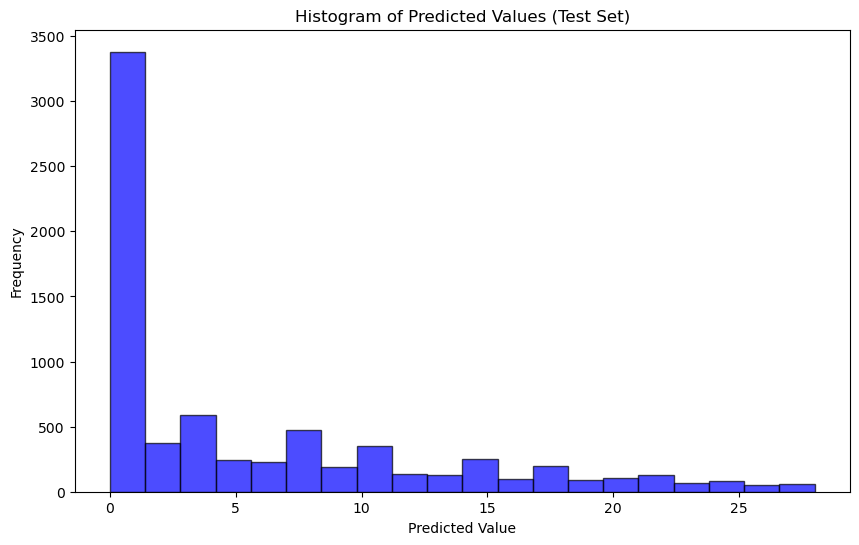

In [94]:
import matplotlib.pyplot as plt

# Make predictions (ensure the model is already trained)
y_test_pred = (model_leaky.predict(X_test_df).flatten() * 28).round().clip(0, 28)

# Plot the histogram of predicted values
plt.figure(figsize=(10, 6))
plt.hist(y_test_pred, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title("Histogram of Predicted Values (Test Set)")
plt.xlabel("Predicted Value")
plt.ylabel("Frequency")
plt.show()


In [95]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l1_l2

# Define the enhanced ANN model
model_regularizer = Sequential([
    Dense(256, input_dim=X_train_df.shape[1], kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(128, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(64, kernel_regularizer=l1_l2(l1=1e-5, l2=1e-4)),
    LeakyReLU(alpha=0.1),
    BatchNormalization(),
    Dropout(0.2),

    Dense(1, activation='sigmoid')  # Sigmoid for scaled target
])

# Compile the model with an advanced optimizer
model_regularizer.compile(optimizer=Adam(learning_rate=0.001), loss='mean_absolute_error')

# Define callbacks
callbacks = [
    EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)
]

# Train the model
history = model_regularizer.fit(
    X_train_df, y_train / 28,  # Rescale target to 0-1
    validation_data=(X_val_df, y_val / 28),  # Rescale target to 0-1
    epochs=100,
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

test_loss = model_regularizer.evaluate(X_test_df, y_test / 28)  # Ensure test targets are scaled
print(f"Test Loss: {test_loss}")


Epoch 1/100


/Users/ognjenradojicic/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/Users/ognjenradojicic/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1054/1054 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step - loss: 0.3254 - val_loss: 0.2651 - learning_rate: 0.0010
Epoch 2/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2654 - val_loss: 0.2442 - learning_rate: 0.0010
Epoch 3/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2446 - val_loss: 0.2319 - learning_rate: 0.0010
Epoch 4/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2310 - val_loss: 0.2196 - learning_rate: 0.0010
Epoch 5/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2202 - val_loss: 0.2163 - learning_rate: 0.0010
Epoch 6/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2197 - val_loss: 0.2115 - learning_rate: 0.0010
Epoch 7/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2106 - val_loss: 0.2095 - learning_rate: 0.0010
Epoch 8/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2129 - val_loss: 0.2076 - learning_rate: 0.0010
Epoch 9/100
1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 0.2108 - val_loss: 0.2074 - learning_rate: 0.

In [96]:
# Make predictions and rescale back to 0-28
y_train_pred = (model_regularizer.predict(X_train_df).flatten() * 28).round().clip(0, 28)
y_val_pred = (model_regularizer.predict(X_val_df).flatten() * 28).round().clip(0, 28)
y_test_pred = (model_regularizer.predict(X_test_df).flatten() * 28).round().clip(0, 28)

# Evaluate the model
train_mae = mean_absolute_error(y_train, y_train_pred)
val_mae = mean_absolute_error(y_val, y_val_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"Training MAE: {train_mae}")
print(f"Validation MAE: {val_mae}")
print(f"Test MAE: {test_mae}")

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 387us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 609us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 423us/step
Training MAE: 5.039848197343454
Validation MAE: 5.288381742738589
Test MAE: 5.318439618204454


In [97]:
from sklearn.inspection import permutation_importance

# Get predictions
predictions = model_regularizer.predict(X_test_df)

# Calculate permutation importance
perm_importance = permutation_importance(
    model_regularizer,
    X_test_df,
    y_test / 28,  # Rescale target to match the model
    scoring='neg_mean_absolute_error',  # Use MAE as the metric
    n_repeats=10,
    random_state=42
)

# Display feature importance
for i in np.argsort(perm_importance.importances_mean)[::-1]:
    print(f"Feature: {X_test_df.columns[i]}, Importance: {perm_importance.importances_mean[i]}")



226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 402us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 392us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 537us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 413us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 417us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 384us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 601us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 405us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 386us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 375us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 389us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 382us/step
226/226 ━━━━━━━━━━━━━━━━━━━━ 0s 414us/step
226/226 ━━━

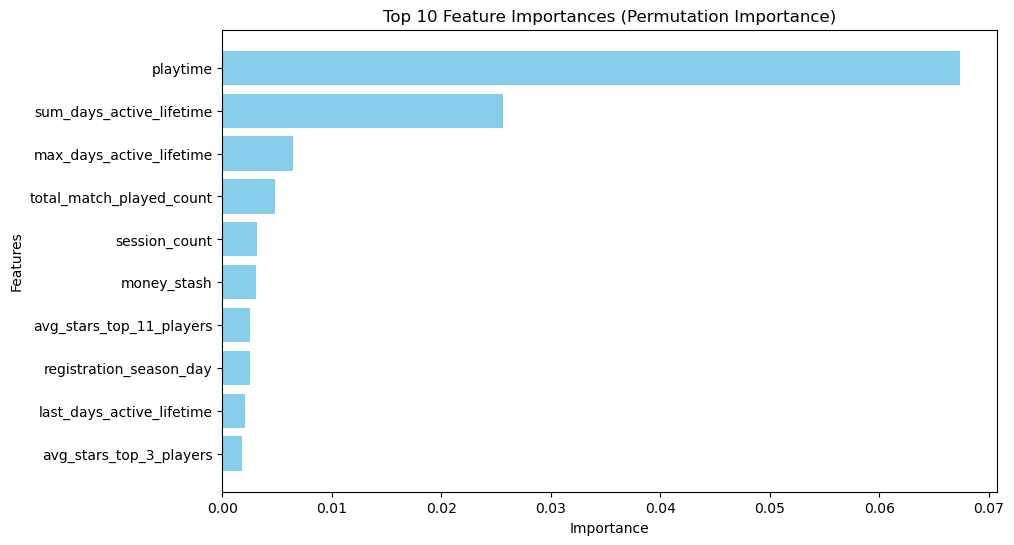

In [98]:
# Extract top 10 feature importance and corresponding feature names
sorted_idx = np.argsort(perm_importance.importances_mean)[::-1][:10]  # Get indices of top 10
feature_names = X_test_df.columns[sorted_idx]
importances = perm_importance.importances_mean[sorted_idx]

# Plot the top 10 feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Top 10 Feature Importances (Permutation Importance)')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature on top
plt.show()